In [1]:
import os
os.environ['THEANO_FLAGS'] = 'device=gpu, floatX=float32'

In [2]:
import ssn
import rf_layer_norm as rf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time

from theano import *
import theano.tensor as T

%matplotlib inline

Using gpu device 0: GeForce GTX 680


In [3]:
# define symbolic variables for theano
dt = T.scalar('dt', dtype='float32')
c = T.scalar("c", dtype='float32')
h = T.matrix("h", dtype='float32')
n_E = T.matrix("n_E", dtype='float32')
n_I = T.matrix("n_I", dtype='float32')
W_EE = T.tensor3("W_EE", dtype='float32')
W_EI = T.tensor3("W_EI", dtype='float32')
W_IE = T.tensor3("W_IE", dtype='float32')
W_II = T.tensor3("W_II", dtype='float32')
k = T.matrix("k", dtype='float32')
tau_E = T.matrix("tau_E", dtype='float32')
tau_I = T.matrix("tau_I", dtype='float32')

I_E = T.matrix('I_E', dtype='float32')
I_I = T.matrix('I_I', dtype='float32')

I_thresh_E = T.matrix('I_thresh_E', dtype='float32')
I_thresh_I = T.matrix('I_thresh_I', dtype='float32')

r_SS_E = T.matrix('r_SS_E', dtype='float32')
r_SS_I = T.matrix('r_SS_I', dtype='float32')

r_e = T.matrix("r_e", dtype='float32')
r_i = T.matrix("r_i", dtype='float32')

# initial firing rates are all zero
r_E = theano.shared(np.zeros((75,75), dtype='float32'))
r_I = theano.shared(np.zeros((75,75), dtype='float32'))

# Compile functions:
I_E = c*h + T.sum(T.sum(W_EE*r_e,1),1).reshape((75,75)).T - T.sum(T.sum(W_EI*r_i,1),1).reshape((75,75)).T
I_I = c*h + T.sum(T.sum(W_IE*r_e,1),1).reshape((75,75)).T - T.sum(T.sum(W_II*r_i,1),1).reshape((75,75)).T

I_thresh_E = T.switch(T.lt(I_E,0), 0, I_E)
I_thresh_I = T.switch(T.lt(I_I,0), 0, I_I)

r_SS_E = k*T.pow(I_thresh_E, n_E)
r_SS_I = k*T.pow(I_thresh_I, n_I)

euler_E = r_e + dt*(-r_e+r_SS_E)/tau_E
euler_I = r_i + dt*(-r_i+r_SS_I)/tau_I

euler = theano.function(inputs=[dt,c,h,W_EE,W_EI,W_IE,W_II,n_E,n_I,k,tau_E,tau_I], 
                            outputs=[r_E, r_I],
                            givens={r_e:r_E, r_i:r_I},
                            updates=[(r_E,euler_E), (r_I,euler_I)],
                            allow_input_downcast=True)

In [4]:
# load Blasdel orientation and ocular dominance maps (previously processed,
# see map_analysis.ipynb
st = time.time()
[OD_map_full, OP_map_full] = np.load('saved_vars/maps-Nov-13.p', 'rb')
print "Elapsed time to load maps: %d seconds" % (time.time() - st)
OD_map = OD_map_full[-75:,-75:]
OP_map = np.floor(OP_map_full[-75:,-75:])

Elapsed time to load maps: 0 seconds


In [5]:
# Generate RF Layer:
start_time = time.time()
RF_layer = rf.rf_layer(OP_map, N_pairs=75, field_size=75)
print "Elapsed time to produce RF layer: %d seconds" % (time.time()-start_time)

Elapsed time to produce RF layer: 1 seconds


In [6]:
# Generate SSN:
ss_net = ssn.SSNetwork(ori_map=OP_map, ocd_map=OD_map)

c0 = 40
dt0 = 0.005
timesteps = 100
dx = ss_net.dx
N_pairs = ss_net.N_pairs

# Cast SSN variables to float32 for Theano:
W_EE0 = ss_net.W_EE.astype('float32')
W_EI0 = ss_net.W_EI.astype('float32')
W_IE0 = ss_net.W_IE.astype('float32')
W_II0 = ss_net.W_II.astype('float32')

k0 = ss_net.k.astype('float32')
n_E0 = ss_net.n_E.astype('float32')
n_I0 = ss_net.n_I.astype('float32')

tau_E0 = ss_net.tau_E.astype('float32')
tau_I0 = ss_net.tau_I.astype('float32')

In [10]:
# Select some random SSN units to probe:
n_units = 10
r_units = np.floor(N_pairs*np.random.rand(n_units,2))

dt0 = 0.005
timesteps = 100

In [12]:
contrast_range_ssn = np.linspace(3,50,10)
contrast_range_rf = np.linspace(0.05,1,10)
ff_ssn_stim = np.zeros((len(r_units), N_pairs, N_pairs))
ff_rf_stim  = np.zeros((len(r_units), len(contrast_range_ssn), N_pairs, N_pairs))

ssn_contrast_results = np.zeros((len(r_units), len(contrast_range_ssn), 2, N_pairs, N_pairs))
rf_contrast_results  = np.zeros((len(r_units), len(contrast_range_rf), 2, N_pairs, N_pairs))

for i in range(len(r_units)):
    xi = r_units[i,0]
    yi = r_units[i,1]
    ff_ssn_stim[i,:,:] = ssn.generate_mono_stimulus(OP_map[yi,xi], 1, [xi*dx, yi*dx], OP_map, full_frame=True )
    raw_img = rf.generate_static_grating(OP_map[yi,xi]*np.pi/180, 75., 2*75, pix_deg=25, phi=0)
    for j in range(len(contrast_range_rf)):
        ff_rf_stim[i,j,:,:] = RF_layer.get_layer_response_rates(contrast_range_rf[j]*raw_img, phase_invariant=True)
        

<matplotlib.colorbar.Colorbar instance at 0x7f77c0b65ef0>

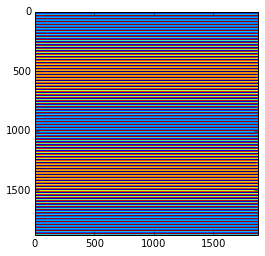

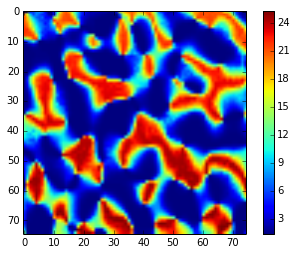

In [21]:
test_img = rf.generate_static_grating(0, 75., 2*75, pix_deg=25, phi=0)
test_resp = RF_layer.get_layer_response_rates(0.5*test_img, phase_invariant=True)
ssn_img = ssn.generate_mono_stimulus(0, 1, [xi*dx, yi*dx], OP_map, full_frame=True )

plt.figure()
plt.imshow(test_img)

plt.figure()
plt.imshow(test_resp)
plt.colorbar()

plt.figure()
plt.imshow(ssn_img)
plt.colorbar()a

plt.figure()
plt.imshow(ssn_img-test_resp)
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f77c1166f38>

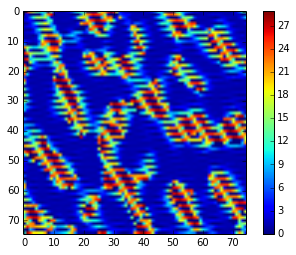

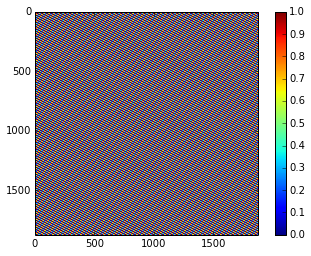

In [16]:
plt.figure()
plt.imshow(ff_rf_stim[1,-1])
plt.colorbar()

plt.figure()
plt.imshow(raw_img)
plt.colorbar()

In [22]:
# run simulations for figure 6B - system transition with contrast for both RF and SSN systems
# RF only:
start_time= time.time()
c0 = 1
for i in range(len(r_units)):
    for j in range(len(contrast_range_rf)):
        h0 = ff_rf_stim[i,j,:,:]
        for t in range(timesteps):
            euler(dt0,c0,h0,W_EE0,W_EI0,W_IE0,W_II0,n_E0,n_I0,k0,tau_E0,tau_I0)
        
        rf_contrast_results[i,j,0] = r_E.get_value()
        rf_contrast_results[i,j,1] = r_I.get_value()
        r_E.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
        r_I.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
        
print "Elapsed time: %d seconds." % (time.time()-start_time)

Elapsed time: 1053 seconds.


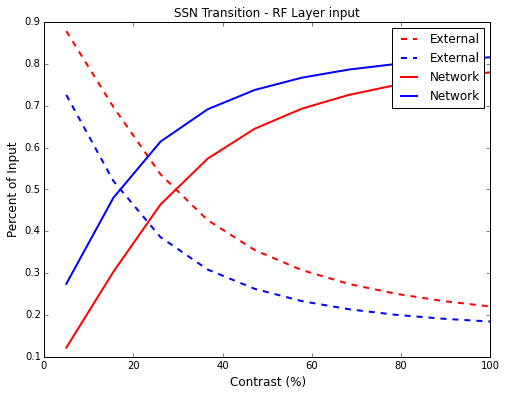

In [29]:
# plot reproductions of figure 6B: RF only
rf_E_external = np.zeros((len(r_units), len(contrast_range_rf)))
rf_I_external = np.copy(rf_E_external)
rf_E_network = np.copy(rf_E_external)
rf_I_network = np.copy(rf_E_external)

for i in range(len(r_units)):
    xi = r_units[i,0]
    yi = r_units[i,1]
    for j in range(len(contrast_range_rf)):
        rf_E_network[i,j] = np.sum(rf_contrast_results[i,j,0]*ss_net.W_EE[yi+xi*N_pairs,:,:] + rf_contrast_results[i,j,1]*ss_net.W_EI[yi+xi*N_pairs,:,:])
        rf_I_network[i,j] = np.sum(rf_contrast_results[i,j,0]*ss_net.W_IE[yi+xi*N_pairs,:,:] + rf_contrast_results[i,j,1]*ss_net.W_II[yi+xi*N_pairs,:,:])
        rf_E_external[i,j] = np.sum(ff_rf_stim[i,j,yi,xi])
        
rf_external_avg = np.mean(rf_E_external,0)
rf_E_net_avg = np.mean(rf_E_network,0)
rf_I_net_avg = np.mean(rf_I_network,0)


plt.figure(figsize=(8, 6))
plt.plot(contrast_range_rf*100, rf_external_avg/(rf_E_net_avg+rf_external_avg), 'r--', linewidth=2, label="External")
plt.plot(contrast_range_rf*100, rf_external_avg/(rf_I_net_avg+rf_external_avg), 'b--', linewidth=2, label="External")
plt.plot(contrast_range_rf*100, rf_E_net_avg/(rf_E_net_avg+rf_external_avg), 'r', linewidth=2, label="Network")
plt.plot(contrast_range_rf*100, rf_I_net_avg/(rf_I_net_avg+rf_external_avg), 'b', linewidth=2, label="Network")

plt.title('SSN Transition - RF Layer input',fontsize=12)
plt.xlabel('Contrast (%)', fontsize=12)
plt.ylabel('Percent of Input', fontsize=12)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.legend(fontsize=12)
#plt.savefig('integrated_transition.eps', format='eps', dpi=1000)

In [30]:
# run simulations for figure 6B - system transition with contrast for both RF and SSN systems
# SSN only:
start_time= time.time()

for i in range(len(r_units)):
    for j in range(len(contrast_range_ssn)):
        xi = r_units[i,0]
        yi = r_units[i,1]
        c0 = contrast_range_ssn[j]
        h0 = ff_ssn_stim[i,:,:]
        for t in range(timesteps):
            euler(dt0,c0,h0,W_EE0,W_EI0,W_IE0,W_II0,n_E0,n_I0,k0,tau_E0,tau_I0)
        ssn_contrast_results[i,j,0] = r_E.get_value()
        ssn_contrast_results[i,j,1] = r_I.get_value()
        r_E.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
        r_I.set_value(np.zeros((N_pairs,N_pairs),dtype='float32'))
        
print "Elapsed time: %d seconds." % (time.time()-start_time)

Elapsed time: 1055 seconds.


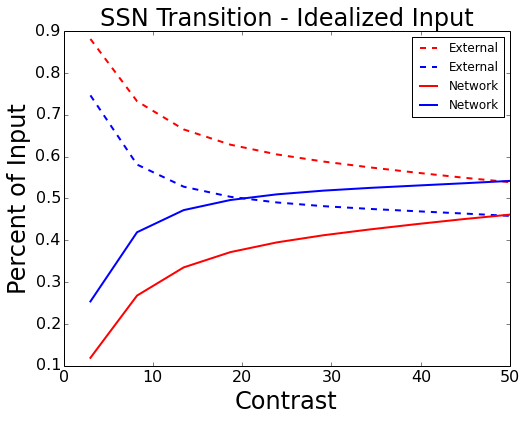

In [31]:
# plot reproductions of figure 6B: SSN only

ssn_E_external = np.zeros((len(r_units), len(contrast_range_ssn)))
ssn_I_external = np.copy(ssn_E_external)
ssn_E_network = np.copy(ssn_E_external)
ssn_I_network = np.copy(ssn_E_external)

for i in range(len(r_units)):
    xi = r_units[i,0]
    yi = r_units[i,1]
    for j in range(len(contrast_range_ssn)):
        ssn_E_network[i,j] = np.sum(ssn_contrast_results[i,j,0]*ss_net.W_EE[yi+xi*N_pairs,:,:] + ssn_contrast_results[i,j,1]*ss_net.W_EI[yi+xi*N_pairs,:,:])
        ssn_I_network[i,j] = np.sum(ssn_contrast_results[i,j,0]*ss_net.W_IE[yi+xi*N_pairs,:,:] + ssn_contrast_results[i,j,1]*ss_net.W_II[yi+xi*N_pairs,:,:])
        ssn_E_external[i,j] = np.sum(ff_ssn_stim[i,yi,xi]*contrast_range_ssn[j])
        
ssn_external_avg = np.mean(ssn_E_external,0)
ssn_E_net_avg = np.mean(ssn_E_network,0)
ssn_I_net_avg = np.mean(ssn_I_network,0)


plt.figure(figsize=(8, 6))
plt.plot(contrast_range_ssn, ssn_external_avg/(ssn_E_net_avg+ssn_external_avg), 'r--', linewidth=2, label="External")
plt.plot(contrast_range_ssn, ssn_external_avg/(ssn_I_net_avg+ssn_external_avg), 'b--', linewidth=2, label="External")
plt.plot(contrast_range_ssn, ssn_E_net_avg/(ssn_E_net_avg+ssn_external_avg), 'r', linewidth=2, label="Network")
plt.plot(contrast_range_ssn, ssn_I_net_avg/(ssn_I_net_avg+ssn_external_avg), 'b', linewidth=2, label="Network")
plt.title('SSN Transition - Idealized Input', fontsize=24)
plt.xlabel('Contrast', fontsize=24)
plt.ylabel('Percent of Input', fontsize=24)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.legend(fontsize=12)
# plt.savefig('ssn_transition.eps', format='eps', dpi=1000)